# Visualize U.S. Rent Data 
I was at a hackathon the other day where a team built a location recommender for future renters with particular budgets in mind. Wow, I thought, something like that could've been really handy during my soul-wrenching apartment huntings in the past! It also reminded me of how little I know about the rent situation in the United States as an international student who's only ever lived in the Bay Area for the past 3 years. Yes, I've heard ghost stories about crazy rental rates here and seen those memes but how does it actually compare to the rest of the nation? 

To develop a better understanding of questions like that, I decided to analyze the [U.S. rent data](https://www.apartmentlist.com/rentonomics/rental-price-data/) between 2014-2019 which I obtained from Apartment List.

In [652]:
# Import those libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import seaborn as sns
import numpy as np
import geopandas as gpd
from scipy.stats import pearsonr
import folium 

## Import and clean data
### Basic cleaning

In [653]:
# Load the data
df = pd.read_csv('Apartment-List-Rent-Data-City_2019-10.csv')
# Replace empty cells with NaNs
df = df.replace('', np.nan)
# Drop the Location_Type column since there's only one type "City" 
df = df.drop(['Location_Type'], axis=1)

In [654]:
# Inspect first 5 rows
df.head()

,Location,State,Bedroom_Size,Price_2014_01,Price_2014_02,Price_2014_03,Price_2014_04,Price_2014_05,Price_2014_06,Price_2014_07,...,Price_2019_01,Price_2019_02,Price_2019_03,Price_2019_04,Price_2019_05,Price_2019_06,Price_2019_07,Price_2019_08,Price_2019_09,Price_2019_10
0,"New York, NY",NY,Studio,1780.0,1778.0,1781.0,1786.0,1794.0,1802.0,1817.0,...,1907.0,1897.0,1889.0,1904.0,1920.0,1936.0,1933.0,1928.0,1922.0,1937
1,"New York, NY",NY,1br,1976.0,1975.0,1978.0,1983.0,1992.0,2001.0,2018.0,...,2118.0,2106.0,2098.0,2114.0,2132.0,2150.0,2146.0,2142.0,2134.0,2151
2,"New York, NY",NY,2br,2354.0,2352.0,2356.0,2362.0,2373.0,2384.0,2404.0,...,2523.0,2509.0,2499.0,2518.0,2540.0,2561.0,2557.0,2551.0,2542.0,2562
3,"New York, NY",NY,3br,3036.0,3033.0,3038.0,3046.0,3060.0,3074.0,3099.0,...,3253.0,3235.0,3222.0,3247.0,3275.0,3302.0,3297.0,3289.0,3278.0,3304
4,"New York, NY",NY,4br,3381.0,3378.0,3383.0,3392.0,3407.0,3424.0,3452.0,...,3623.0,3603.0,3588.0,3616.0,3648.0,3677.0,3672.0,3663.0,3651.0,3680


### Reshape from wide to long
Apartment List organized their data in a **wide format** where one columns stores rental prices at one time point. To plot with Seaborn, however, we need the data in a long format: All rental prices will be stored in a single column, with an additional column specifying the time point where each row was from. I followed this particularly relevant [example](https://riptutorial.com/pandas/example/14482/pandas-melt-to-go-from-wide-to-long) to implement the conversion.

In [655]:
# Each column name (after the first 3) is a time point
timepts = df.columns[3:].tolist()

In [656]:
# Use the .melt() method to reshape data
  # Rental prices will be stored in a single column called "Rent"
  # A new column "Year-Month" stores the time point of each rental price 
rents = pd.melt(df, id_vars=['Location','State', 'Bedroom_Size'],
                value_vars=timepts,
                var_name='Year-Month', value_name='Rent')

In [657]:
# Replace "Price_" with empty strings
rents['Year-Month'] = rents['Year-Month'].str.replace('Price_','')

In [658]:
# Convert strings in Year-Month to datetime objects
from datetime import datetime

# Year and month are connected to by "_"
rents['Year-Month'] = pd.to_datetime(rents['Year-Month'], format='%Y_%m')
# Extract year
rents['Year'] = pd.DatetimeIndex(rents['Year-Month']).year
# Extract month
rents['Month'] = pd.DatetimeIndex(rents['Year-Month']).month

In [659]:
# Seperate cities from Location
locations = rents['Location'].str.split(", ", n = 1, expand = True) 
rents['City'] = locations[0]

In [660]:
# Now take a look again
rents.head()

,Location,State,Bedroom_Size,Year-Month,Rent,Year,Month,City
0,"New York, NY",NY,Studio,2014-01-01,1780.0,2014,1,New York
1,"New York, NY",NY,1br,2014-01-01,1976.0,2014,1,New York
2,"New York, NY",NY,2br,2014-01-01,2354.0,2014,1,New York
3,"New York, NY",NY,3br,2014-01-01,3036.0,2014,1,New York
4,"New York, NY",NY,4br,2014-01-01,3381.0,2014,1,New York


## Visualizations

### National averages
Let's first look at the national averages of rent for different bedroom sizes. We can use violin plots to show the entire distributions.

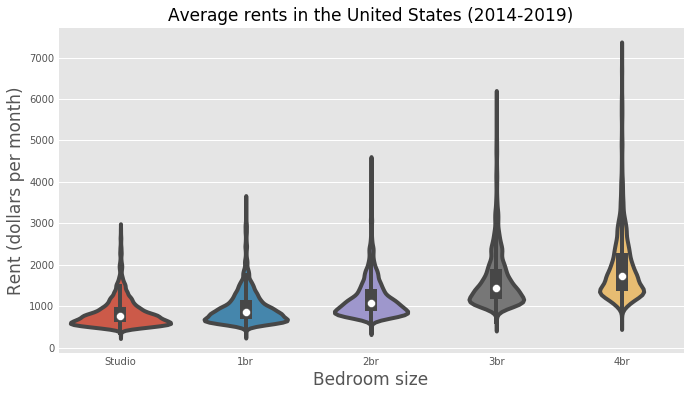

In [661]:
plt.figure(figsize=(10, 6))
g = sns.violinplot(x="Bedroom_Size", y="Rent", data=rents)
plt.xlabel('Bedroom size', fontsize=17)
plt.ylabel('Rent (dollars per month)', fontsize=17)
plt.title('Average rents in the United States (2014-2019)', fontsize = 17)
plt.show()

The national average of one bedrooms is a little under 1000 per month; I'm paying over twice more for my one bedroom in Berkeley, putting me in the top/right tail of the distribution. Still, Berkeley has the [lowest rents](https://sf.curbed.com/2018/5/3/17316196/berkeley-rent-median-numbers-san-francisco-2018-cost) in the Bay Area! Fortunately, average rents don't increase sharply with bedroom sizes, which makes sharing rents with roommates a viable surviving strategy.

### Changes over time
In less than 4 years in the U.S., I've seen several hefty rent increases. How much did rents actually go up over the past 5 years?

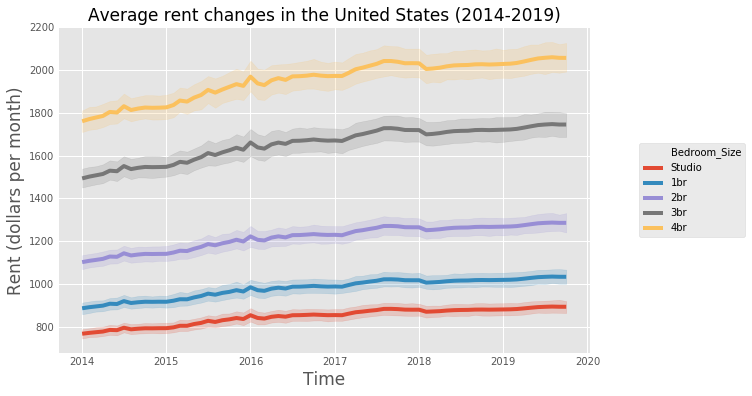

In [662]:
plt.figure(figsize=(10, 6))
g = sns.lineplot(x="Year-Month", y="Rent", hue="Bedroom_Size", data=rents)
plt.xlabel('Time', fontsize=17)
plt.ylabel('Rent (dollars per month)', fontsize=17)
plt.title('Average rent changes in the United States (2014-2019)', fontsize=17)

# Put legend to the right side
box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position
g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1)

plt.show()

Compared to the beginning of 2014, now an average U.S. renter has to pay 100 dollars more per month for studios and one bedrooms and 200 dollars more per month for 2, 3, and 4 bedrooms.

### Top and bottom 10 cities
Which U.S. cities have the highest and the lowest average rents between 2014-2019?

In [663]:
# Create a new dataframe with the average rent of each city
city_means = rents.groupby('Location').mean()

# Sort by rent from high to low
city_means = city_means.sort_values(by=['Rent'], ascending=False)

# Top 10 list
top_10_names = city_means.index[:10].tolist()

# Bottom 10 list
bottom_10_names = city_means.index[-10:].tolist()

# Select top 10 cities from the dataframe "rents"
top_10 = rents.loc[rents['Location'].isin(top_10_names)]

# Select bottom 10 cities from the dataframe "rents"
bottom_10 = rents.loc[rents['Location'].isin(bottom_10_names)]

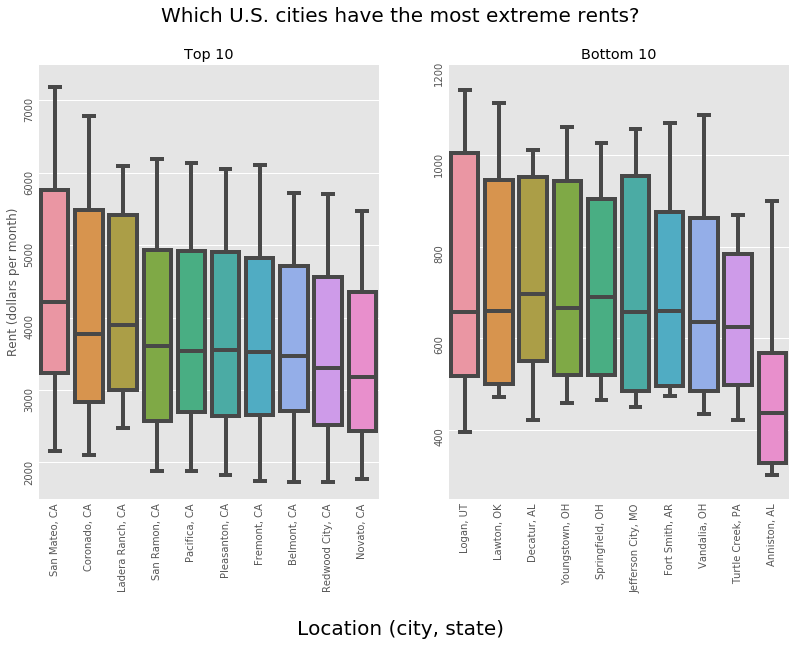

In [664]:
f, axes = plt.subplots(1, 2, figsize=(12,8))

# Plot
sns.boxplot(x="Location", y="Rent", data=top_10, order=top_10_names, orient='v' , ax=axes[0])
sns.boxplot(x="Location", y="Rent", data=bottom_10, order=bottom_10_names, orient='v' , ax=axes[1])

# Subplot titles and axes
axes[0].set_title('Top 10')
axes[1].set_title('Bottom 10')
axes[0].tick_params(labelrotation=90)
axes[1].tick_params(labelrotation=90)
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[0].set_ylabel('Rent (dollars per month)')
axes[1].set_ylabel('')
axes[0].set_ylim([1500, 7500])
axes[1].set_ylim([250, 1200])

# Commpn titles
f.text(0.5, -0.1, 'Location (city, state)', ha='center', va='center', fontsize=20)
f.suptitle('Which U.S. cities have the most extreme rents?', fontsize=20)

plt.show()

Among all 675 U.S. cities in the records, San Mateo has the highest rent among all, which soars above 4000 dollars per month; by contrast, Anniston has the lowest rent, which is only about 400 dollars per month. Not so surprisingly, all top 10 cities are in California — 8 are in the Bay Area, one in the Greater Los Angles area, and one adjacent to San Diego.

### Percentage increases
In which cities can we find the highest and lowest percentage increases in the United States? Let's find out the odd balls!

In [805]:
# Rent on Jan. 01, 2014
start = rents.loc[rents['Year-Month'] == ('2014-01-01 00:00:00')]
start.reset_index(drop=True, inplace=True)

# Rent on Oct. 01, 2019
end = rents.loc[rents['Year-Month'] == ('2019-10-01 00:00:00')]
end.reset_index(drop=True, inplace=True)

# Calculate increase and % increase
start.loc[:, 'Increase'] = end['Rent'] - start['Rent']
start.loc[:, 'Pct_Increase'] = start['Increase'] / start['Rent'] * 100

# Some cities don't have records in 2014
start = start.dropna()

# Create a new dataframe with the average percentage increase of each city
city_increase_means = start.groupby('Location').mean()

In [666]:
# Sort by rent increase from high to low
city_increase_means = city_increase_means.sort_values(by=['Pct_Increase'], ascending=False)

# Top 10 list
top_increase_10_names = city_increase_means.index[:10].tolist()

# Bottom 10 list
bottom_increase_10_names = city_increase_means.index[-10:].tolist()

# Select top 10 cities from the dataframe "rents"
top_10_increase = start.loc[start['Location'].isin(top_increase_10_names)]

# Select bottom 10 cities from the dataframe "rents"
bottom_10_increase = start.loc[start['Location'].isin(bottom_increase_10_names)]

# Combine the above into 20 cities with extreme changes
extreme_10 = top_10_increase.append(bottom_10_increase)
extreme_10_names = top_increase_10_names + bottom_increase_10_names

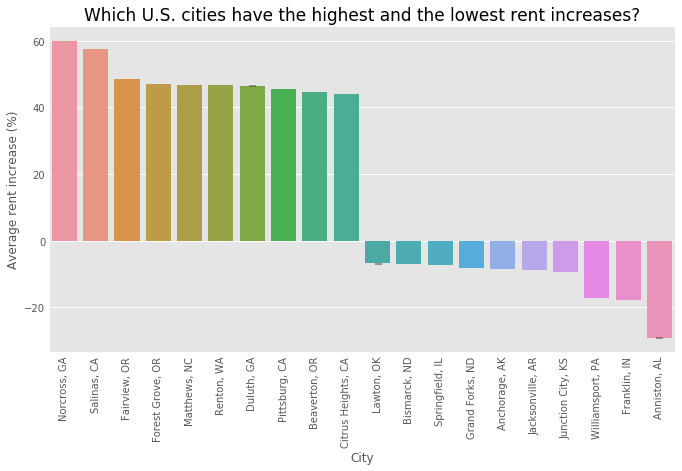

In [667]:
plt.figure(figsize=(10, 6))

sns.barplot(x="Location", y="Pct_Increase", data=extreme_10, order=extreme_10_names)

plt.xticks(rotation=90)
plt.ylabel('Average rent increase (%)')
plt.xlabel('City')
plt.title('Which U.S. cities have the highest and the lowest rent increases?', fontsize=17)

plt.show()

In cities such as Norcross, Salinas, Fairview, etc., rent has increased by over 40% in the past 5 years. In others like Anniston, Franklin, Williamsport, etc., rent has even gone down by about 20%.

#### Rents and rent increases
Do cities with high rents also tend to have shaper rent increases? We can use a [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html) to show the distribution of each variable and as well as the relationship between them.

In [668]:
# Drop irrelevant variables
means = city_means.drop(['Year', 'Month'], axis=1)
increases = city_increase_means.drop(['Rent', 'Year', 'Month', 'Increase'], axis=1)

# Concatenate average rents and rent increases
changes = means.join(increases, how='outer')

# Drop infinity and NaNs
changes = changes[~changes.isin([np.nan, np.inf, -np.inf]).any(1)]

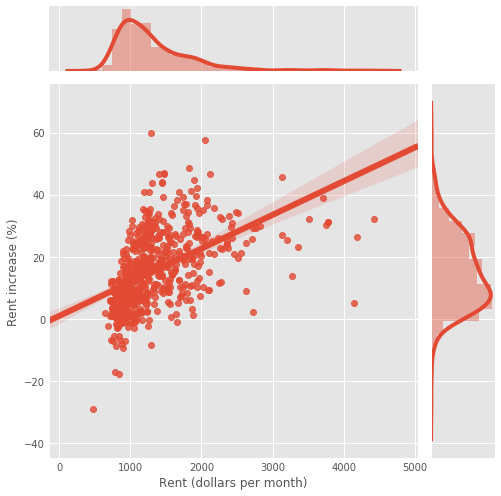

In [669]:
# Use pair plots to show relationships between rent and rent increases
sns.jointplot('Rent', 'Pct_Increase', data=changes, kind="reg", height=7)
plt.xlabel('Rent (dollars per month)')
plt.ylabel('Rent increase (%)')

plt.show()

In [670]:
# Exclude NaNs and infinity 
changes = changes[~changes.isin([np.nan, np.inf, -np.inf]).any(1)]

# Use Pearson's correlatiob
pearsonr(changes['Rent'], changes['Pct_Increase'])

(0.5003797011027383, 7.45438172605595e-42)

Cities with higher rents also have significantly higher percentage increases in rents, Pearson's $r$ = .50, $p$ < .001. It's worrying that expensive areas become even less affordable at a faster pace. 

### Rents on the map
States.

In [931]:
# Pathname of the GeoJSON file
state_map = 'us-states.json'

In [932]:
# Average rents by state
state_rent = rents.groupby(['State']).mean().drop(['Year', 'Month'], axis = 1)
state_rent['State'] = state_rent.index

In [1006]:
# Create 4 bins of rents
bins = list(state_rent['Rent'].quantile([0, 0.25, 0.5, 0.75, 1]))

# Create a choropleth graph
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_map,
    name='choropleth',
    data=state_rent,
    columns=['State', 'Rent'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average rent (dollars per month)',
    bins=bins,
    reset=True
).add_to(m)

folium.LayerControl().add_to(m)

m

We can also look at average rents on the county level.

In [1001]:
# Find the county of each U.S. city 
cities = pd.read_csv('uscities.csv')
cities = cities[['city','state_id', 'county_name']]
cities.loc[:, 'location'] = cities[['city', 'state_id']].apply(lambda x: ', '.join(x), axis=1)
merged = rents.set_index('Location').join(cities.set_index('location'))

# Average rents by county
county_rent = merged.groupby(['county_name']).mean().drop(['Year', 'Month'], axis=1)
county_rent['County'] = county_rent.index

In [1002]:
# Pathname of the GeoJSON file
county_map = 'us-counties.json'

In [1012]:
# Create a choropleth graph
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=county_map,
    name='choropleth',
    data=county_rent,
    columns=['County', 'Rent'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average rent (dollars per month)'
).add_to(m)

folium.LayerControl().add_to(m)

m

Too much mission data on the county level. Also possible that there's simply no rental properties in remote areas. Still, the only crazy part seems to come from the Bay Area.